In [113]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model 

# from tensorflow.keras.optimizers.legacy import RMSprop

# from tensorflow.keras.optimizers.legacy import Adam

import random

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

In [114]:
file_dir = '/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/data/uae_nrel_data.csv'
# output_folder = 'assets/arch'
# os.makedirs(output_folder, exist_ok=True)

year=2022

time_step = 24
num_feats = 5
evaluation_results = []

neurons = 500
epochs = 20
batch_size = 64

In [115]:

def minmaxscaling():
    input_scaler = MinMaxScaler()
    output_scaler = MinMaxScaler()
    return input_scaler, output_scaler

def minmaxscaling_feature_range():
    input_scaler = MinMaxScaler(feature_range = (0,1))
    output_scaler = MinMaxScaler(feature_range = (0,1))
    return input_scaler, output_scaler

def evaluate_model(y_true, y_pred, model_name, dataset_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)


    evaluation_results.append({
        'Model': model_name,
        'Dataset': dataset_type,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

# Step 4: Prepare data for BiLSTM
# def create_dataset(dataset, time_step):
#     print(f'dataset shape {dataset.shape}')
#     dataX, dataY = [], []
#     for i in range(len(dataset) - time_step):
#         a = dataset[i:(i + time_step), :]  # Features: GHI and Energy delta
#         dataX.append(a)
#         dataY.append(dataset[i + time_step, 0])  # Target: Energy delta
#     return np.array(dataX), np.array(dataY)

def create_dataset (X, y, time_steps):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)

def build_bilstm_model(time_step):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(time_step, num_feats))))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(Dense(1)) # output layer

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_learning_curve(history, model_name):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.figure(figsize=(10,6))
  plt.plot(epochs, loss, 'b-', label='Training Loss')
  plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
  plt.title(f'Learning curve: {model_name}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  save_path = os.path.join('/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/GBDT-BILSTM/assets/learning_curves/multi_variate', f'{model_name}_learning_curve.png')
  plt.savefig(save_path)
  print(f'plot saved to {save_path}')
  plt.show()
  plt.close()


def read_data():
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])
#   year = 2022
  data_2022 = data[data.index.year == year]
  data = data_2022[data_2022.index.month == 4]
  return data

In [116]:
data = read_data()

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_49008/2362433901.py:79: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


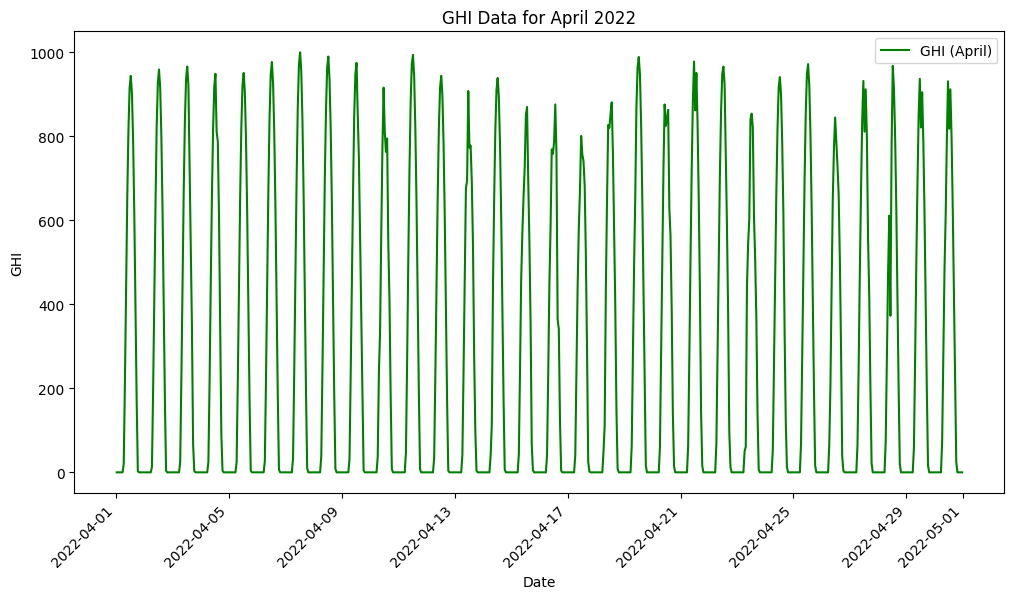

In [117]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['GHI'], label='GHI (April)', color='green')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('GHI')
plt.title(f'GHI Data for April {year}')
plt.legend()
plt.show()

In [118]:
# data = data[(data.index.year == year)]

# dataset = data[['Temperature', 'DNI', 'DHI', 'GHI', 'Pressure', 'Wind Speed']]
# dataset = data[['GHI']]

dataset = data[['Temperature', 'GHI', 'Pressure', 'Wind Speed']]

In [119]:
dataset.head()

,Temperature,GHI,Pressure,Wind Speed
Datetime,,,,
2022-04-01 00:30:00,21.8,0,1013,2.6
2022-04-01 01:30:00,21.8,0,1013,2.3
2022-04-01 02:30:00,21.8,0,1012,2.2
2022-04-01 03:30:00,21.7,0,1012,2.2
2022-04-01 04:30:00,21.5,0,1013,2.4


### BiLSTM

In [120]:
train_size = int(len(dataset)*0.8)
train_dataset, test_dataset = dataset.iloc[:train_size], dataset.iloc[train_size:]

Dimension of train data:  (576, 4)
Dimension of test data:  (144, 4)


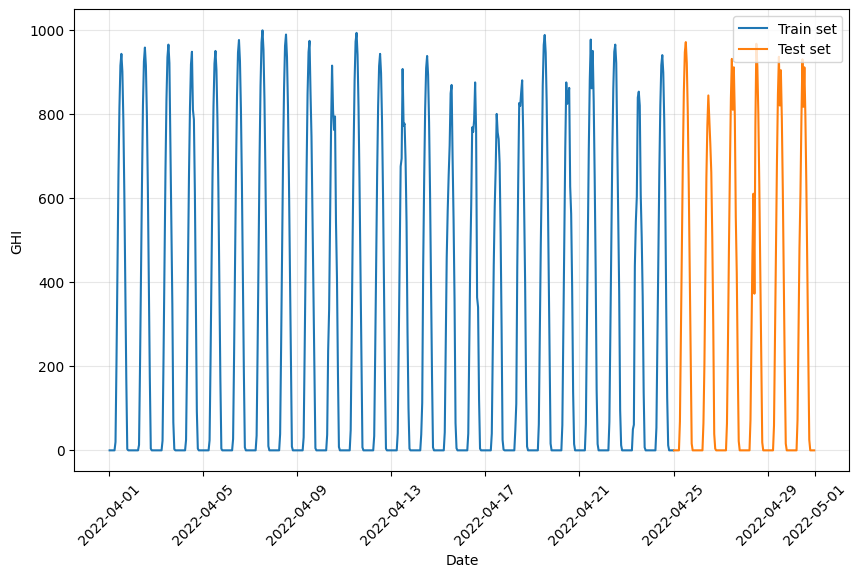

In [121]:
# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(train_dataset.GHI)
plt.plot(test_dataset.GHI)
plt.grid(alpha=0.3)
plt.xlabel('Date')
plt.ylabel('GHI')
plt.legend(['Train set', 'Test set'], loc='upper right')
plt.xticks(rotation=45)

#plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/2.jpg', format='jpg', dpi=1000)

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [122]:
# Split train data to X and y
X_trainy = train_dataset.drop('GHI', axis = 1)
y_trainy = train_dataset.loc[:,['GHI']]

# Split test data to X and y
X_testy = test_dataset.drop('GHI', axis = 1)
y_testy = test_dataset.loc[:,['GHI']]

In [123]:
scaler_x, scaler_y = minmaxscaling()

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_trainy)
output_scaler = scaler_y.fit(y_trainy)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_trainy)
train_x_norm = input_scaler.transform(X_trainy)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_testy)
test_x_norm = input_scaler.transform(X_testy)

In [124]:

TIME_STEPS = 24

X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape)

X_train.shape:  (120, 24, 3)
y_train.shape:  (552, 1)
X_test.shape:  (120, 24, 3)
y_test.shape:  (552, 1)


### commented

In [125]:
# model = build_bilstm_model(time_step)

bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(600, activation='relu', return_sequences=True, input_shape=(time_step, num_feats))))
bilstm_model.add(Dropout(0.1))
bilstm_model.add(Bidirectional(LSTM(600, activation='relu', return_sequences=False)))
bilstm_model.add(Dropout(0.1))
bilstm_model.add(Dense(1)) # output layer
# Compile the model
bilstm_model.compile(optimizer='adam', loss='mean_squared_error')

### cont..

In [126]:
bilstm_history = bilstm_model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
9/9 [==============================] - 25s 2s/step - loss: 0.1192 - val_loss: 0.0721
Epoch 2/20
9/9 [==============================] - 17s 2s/step - loss: 0.0509 - val_loss: 0.0162
Epoch 3/20
9/9 [==============================] - 15s 2s/step - loss: 0.0177 - val_loss: 0.0087
Epoch 4/20
9/9 [==============================] - 14s 2s/step - loss: 0.0124 - val_loss: 0.0062
Epoch 5/20
9/9 [==============================] - 14s 2s/step - loss: 0.0071 - val_loss: 0.0065
Epoch 6/20
9/9 [==============================] - 14s 2s/step - loss: 0.0060 - val_loss: 0.0071
Epoch 7/20
9/9 [==============================] - 14s 2s/step - loss: 0.0056 - val_loss: 0.0054
Epoch 8/20
9/9 [==============================] - 14s 2s/step - loss: 0.0050 - val_loss: 0.0052
Epoch 9/20
9/9 [==============================] - 15s 2s/step - loss: 0.0047 - val_loss: 0.0066
Epoch 10/20
9/9 [==============================] - 13s 1s/step - loss: 0.0038 - val_loss: 0.0062
Epoch 11/20
9/9 [======================

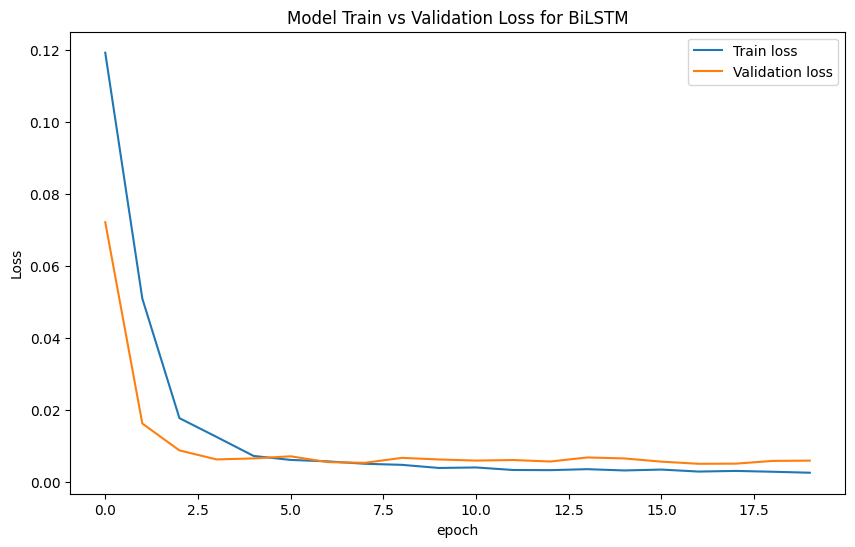

In [127]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (bilstm_history, 'BiLSTM')

In [128]:
# Note that I have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [129]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(bilstm_model)

4/4 [==============================] - 2s 254ms/step


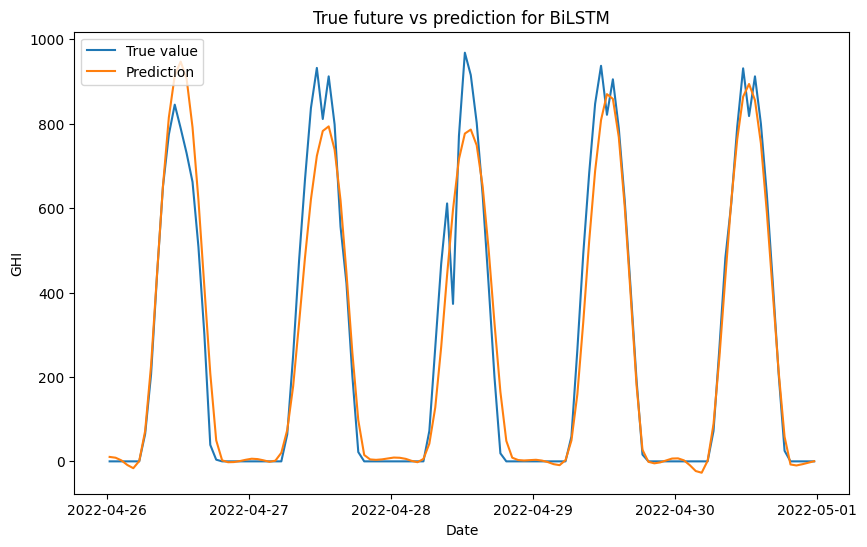

In [130]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)
    prediction_index = dataset.index[-range_future:]  

    plt.plot(prediction_index, np.array(y_test), label='True value')
    plt.plot(prediction_index, np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_bilstm, 'BiLSTM', y_test)

In [131]:
def evaluate_model(y_true, y_pred, model_name, dataset_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Append metrics to evaluation_results
    evaluation_results.append({
        'Model': model_name,
        'Dataset': dataset_type,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

In [132]:
evaluate_model(y_test, prediction_bilstm, 'BiLSTM', 'Testing')

In [133]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Testing,46.76845,5848.908008,76.478154,0.949848


### GBDT-BiLSTM

In [134]:

data = read_data()


# dataset = data[['Temperature', 'DNI', 'DHI', 'GHI', 'Pressure', 'Wind Speed']]
dataset = data[['Temperature', 'GHI', 'Pressure', 'Wind Speed']]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_49008/2362433901.py:79: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


In [135]:
train_size = int(len(dataset)*0.8)
train_dataset, test_dataset = dataset.iloc[:train_size], dataset.iloc[train_size:]


In [136]:
# Split train data to X and y
X_trainy = train_dataset.drop('GHI', axis = 1)
y_trainy = train_dataset.loc[:,['GHI']]

# Split test data to X and y
X_testy = test_dataset.drop('GHI', axis = 1)
y_testy = test_dataset.loc[:,['GHI']]

In [137]:
# X = dataset.iloc[:, 1:].values  # Features
# y = dataset.iloc[:, 0].values   # Target

# train_size = int(len(X) * 0.8)
# test_size = len(X) - train_size
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [138]:
# Step 1: Train GBDT, XGB, and CatBoost on the training data
gbdt = GradientBoostingRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

gbdt.fit(X_trainy, y_trainy)

# Step 2: Get predictions for all models on both training and test sets
gbdt_output_train = gbdt.predict(X_trainy)
gbdt_output_test = gbdt.predict(X_testy)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


In [139]:
# input_scaler = MinMaxScaler(feature_range = (0,1))
# output_scaler = MinMaxScaler(feature_range = (0,1))

# input_scaler = MinMaxScaler()
# output_scaler = MinMaxScaler()

input_scaler, output_scaler = minmaxscaling()

input_scaler.fit(gbdt_output_train.reshape(-1, 1))
# output_scaler.fit(gbdt_output_train.reshape(-1, 1))


train_x_norm = input_scaler.transform(gbdt_output_train.reshape(-1, 1))
test_x_norm = input_scaler.transform(gbdt_output_test.reshape(-1, 1))


In [140]:

output_scaler.fit(y_trainy)

train_y_norm = output_scaler.transform(y_trainy)
test_y_norm = output_scaler.transform(y_testy)


In [141]:
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)


X_train.shape: (552, 24, 3)
y_train.shape: (552, 1)
X_test.shape: (120, 24, 3)
y_test.shape: (120, 1)


In [143]:
TIME_STEPS = 24
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)


# X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape) #
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape) #

X_train.shape:  (120, 24, 1)
y_train.shape:  (552, 1)
X_test.shape:  (120, 24, 1)
y_test.shape:  (552, 1)


### GBDT_BiLSTM component

In [144]:
gbdt_model = build_bilstm_model(time_step)

In [145]:
gbdt_history = gbdt_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
9/9 [==============================] - 15s 1s/step - loss: 0.0965 - val_loss: 0.0574
Epoch 2/20
9/9 [==============================] - 10s 1s/step - loss: 0.0207 - val_loss: 0.0299
Epoch 3/20
9/9 [==============================] - 10s 1s/step - loss: 0.0145 - val_loss: 0.0216
Epoch 4/20
9/9 [==============================] - 10s 1s/step - loss: 0.0095 - val_loss: 0.0196
Epoch 5/20
9/9 [==============================] - 16s 2s/step - loss: 0.0089 - val_loss: 0.0201
Epoch 6/20
9/9 [==============================] - 17s 2s/step - loss: 0.0077 - val_loss: 0.0208
Epoch 7/20
9/9 [==============================] - 11s 1s/step - loss: 0.0076 - val_loss: 0.0158
Epoch 8/20
9/9 [==============================] - 15s 2s/step - loss: 0.0073 - val_loss: 0.0156
Epoch 9/20
9/9 [==============================] - 16s 2s/step - loss: 0.0072 - val_loss: 0.0146
Epoch 10/20
9/9 [==============================] - 9s 962ms/step - loss: 0.0063 - val_loss: 0.0139
Epoch 11/20
9/9 [====================

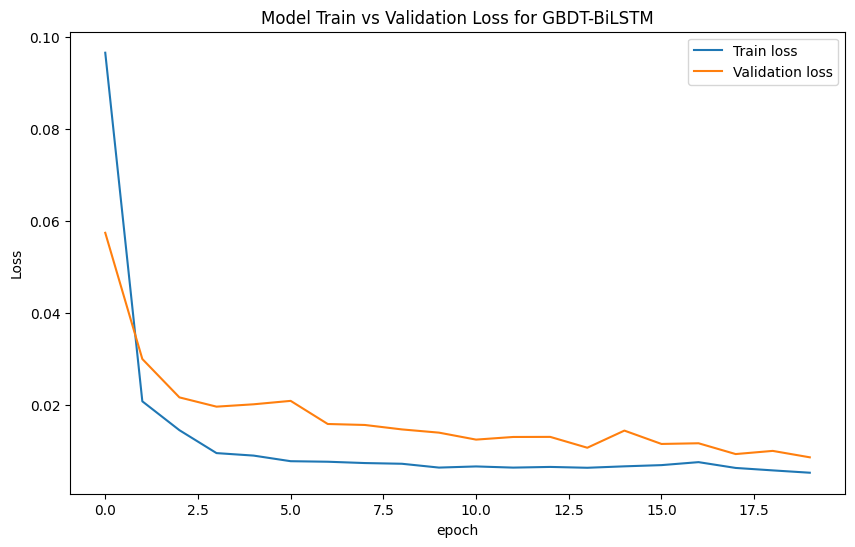

In [146]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (gbdt_history, 'GBDT-BiLSTM')

In [147]:
# Note that I have to use scaler_y
y_test = output_scaler.inverse_transform(y_test)
y_train = output_scaler.inverse_transform(y_train)

In [148]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_gbdt_bilstm = prediction(gbdt_model)

4/4 [==============================] - 1s 78ms/step


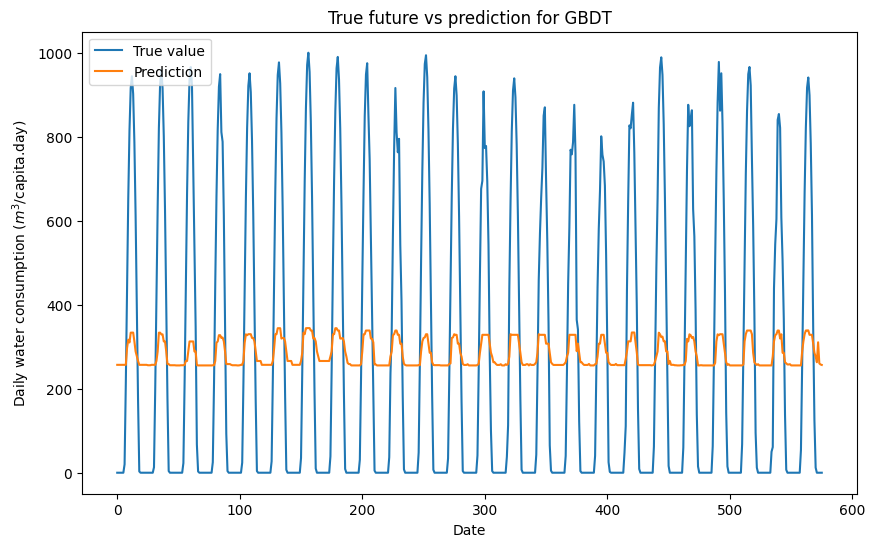

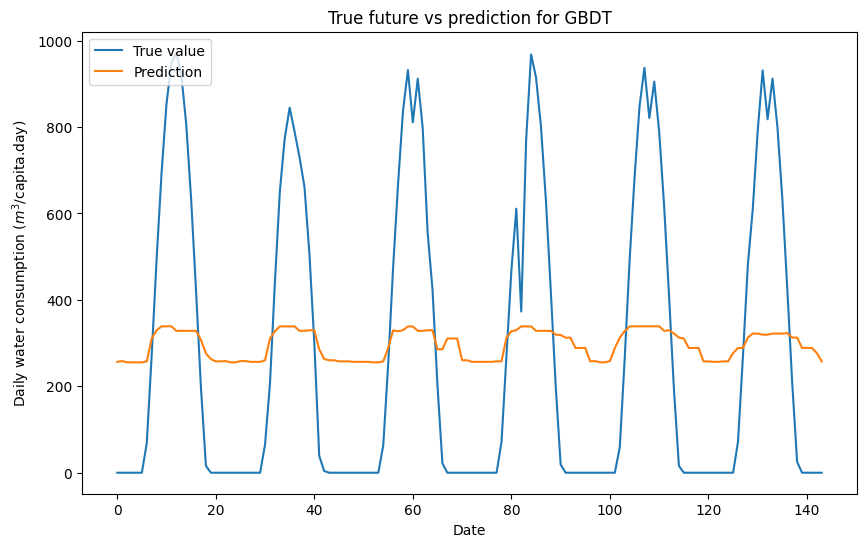

In [149]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True value')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Daily water consumption ($m^3$/capita.day)')
    
    
plot_future(gbdt_output_train, 'GBDT', y_trainy)
plot_future(gbdt_output_test, 'GBDT', y_testy)

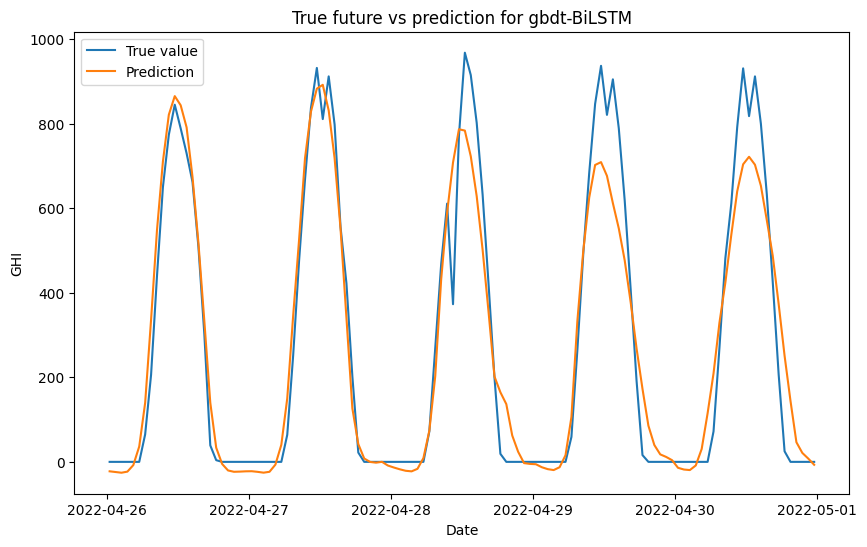

In [150]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)
    prediction_index = dataset.index[-range_future:]  

    plt.plot(prediction_index, np.array(y_test), label='True value')
    plt.plot(prediction_index, np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_gbdt_bilstm, 'gbdt-BiLSTM', y_test)

In [151]:
# Evaluate model performance on training and test sets
evaluate_model(y_trainy, gbdt_output_train, 'gbdt', 'Training')
evaluate_model(y_testy, gbdt_output_test, 'gbdt', 'Testing')

In [152]:
# Evaluate model performance on training and test sets
evaluate_model(y_test, prediction_gbdt_bilstm, 'GBDT-BiLSTM', 'Testing')
# evaluate_model(y_testy, gbdt_output_test, 'GBDT', 'Testing')

In [153]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'GBDT-BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
3,GBDT-BiLSTM,Testing,63.175026,8552.562955,92.480068,0.926666


## catboost-bilstm

In [154]:
data = read_data()

# dataset = data[['Temperature', 'DNI', 'DHI', 'GHI', 'Pressure', 'Wind Speed']]
dataset = data[['Temperature', 'GHI', 'Pressure', 'Wind Speed']]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_49008/2362433901.py:79: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


In [155]:
train_size = int(len(dataset)*0.8)
train_dataset, test_dataset = dataset.iloc[:train_size], dataset.iloc[train_size:]

In [156]:
# Split train data to X and y
X_trainy = train_dataset.drop('GHI', axis = 1)
y_trainy = train_dataset.loc[:,['GHI']]

# Split test data to X and y
X_testy = test_dataset.drop('GHI', axis = 1)
y_testy = test_dataset.loc[:,['GHI']]

In [157]:
catboost = CatBoostRegressor(n_estimators=100, learning_rate=0.001, depth=5, verbose=0)

catboost.fit(X_trainy, y_trainy)

In [158]:
catboost_output_train = catboost.predict(X_trainy)
catboost_output_test = catboost.predict(X_testy)

In [159]:
# input_scaler = MinMaxScaler(feature_range = (0,1))
# output_scaler = MinMaxScaler(feature_range = (0,1))

# input_scaler = MinMaxScaler()
# output_scaler = MinMaxScaler()

# input_scaler, output_scaler = minmaxscaling()

input_scaler.fit(catboost_output_train.reshape(-1, 1))
# output_scaler.fit(catboost_output_test.reshape(-1, 1))

train_x_norm = input_scaler.transform(catboost_output_train.reshape(-1, 1))
test_x_norm = input_scaler.transform(catboost_output_test.reshape(-1, 1))


In [160]:

output_scaler.fit(y_trainy)

train_y_norm = output_scaler.transform(y_trainy)
test_y_norm = output_scaler.transform(y_testy)

In [161]:
# def create_dataset (X, y, time_steps = 1):
#     Xs, ys = [], []
    
#     for i in range(len(X)-time_steps):
#         v = X[i:i+time_steps, :]
#         Xs.append(v)
#         ys.append(y[i+time_steps])
        
#     return np.array(Xs), np.array(ys)

TIME_STEPS = 24
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)


# X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape) #
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape) #

X_train.shape:  (120, 24, 1)
y_train.shape:  (552, 1)
X_test.shape:  (120, 24, 1)
y_test.shape:  (552, 1)


### Catboost-BiLSTM component

In [162]:
catboost_model = build_bilstm_model(time_step)
catboost_history = catboost_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
9/9 [==============================] - 12s 983ms/step - loss: 0.1091 - val_loss: 0.0455
Epoch 2/20
9/9 [==============================] - 10s 1s/step - loss: 0.0226 - val_loss: 0.0126
Epoch 3/20
9/9 [==============================] - 14s 2s/step - loss: 0.0107 - val_loss: 0.0125
Epoch 4/20
9/9 [==============================] - 12s 1s/step - loss: 0.0080 - val_loss: 0.0150
Epoch 5/20
9/9 [==============================] - 9s 1s/step - loss: 0.0076 - val_loss: 0.0112
Epoch 6/20
9/9 [==============================] - 9s 1s/step - loss: 0.0067 - val_loss: 0.0136
Epoch 7/20
9/9 [==============================] - 9s 955ms/step - loss: 0.0068 - val_loss: 0.0129
Epoch 8/20
9/9 [==============================] - 8s 929ms/step - loss: 0.0068 - val_loss: 0.0105
Epoch 9/20
9/9 [==============================] - 9s 952ms/step - loss: 0.0067 - val_loss: 0.0099
Epoch 10/20
9/9 [==============================] - 9s 1s/step - loss: 0.0068 - val_loss: 0.0119
Epoch 11/20
9/9 [================

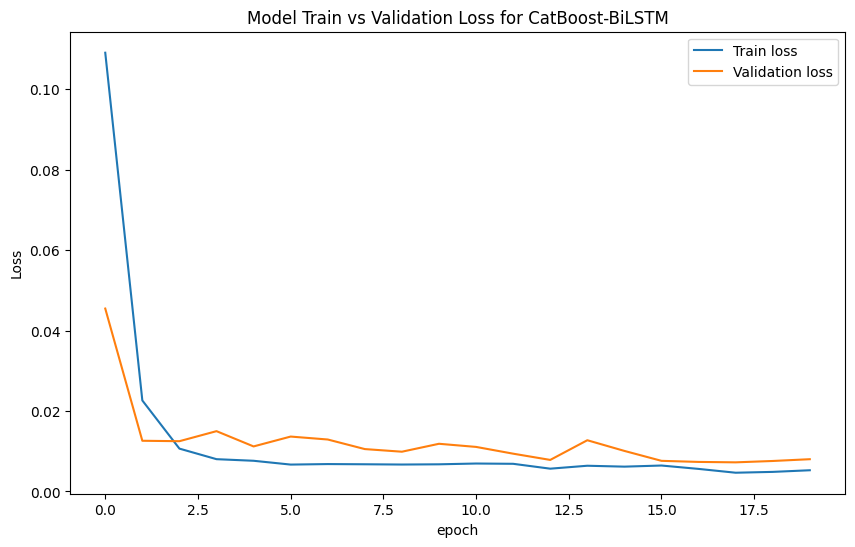

In [163]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (catboost_history, 'CatBoost-BiLSTM')

In [164]:
def predict_day_ahead(model, last_known_sequence, time_step, scaler, steps_ahead=24):
    predictions = []
    
    # Predict step by step for the next 24 hours (steps_ahead)
    for _ in range(steps_ahead):
        # Reshape the last known sequence into the correct shape for the model (samples, time steps, features)
        last_known_sequence = last_known_sequence.reshape(1, time_step, 1)
        
        # Get the model's prediction (next time step)
        prediction = model.predict(last_known_sequence)
        
        # Inverse transform the prediction to get the original scale
        prediction = scaler.inverse_transform(prediction)
        
        # Store the prediction
        predictions.append(prediction[0, 0])  # Assuming the output is 1D (single value per prediction)
        
        # Update the last_known_sequence by appending the predicted value
        # Shift the sequence for the next prediction
        last_known_sequence = np.append(last_known_sequence[:, 1:, :], prediction.reshape(1, 1, -1), axis=1)
    
    return np.array(predictions)

In [165]:
X_test[-1]

array([[0.1081964 ],
       [0.11394353],
       [0.05491062],
       [0.05546827],
       [0.10226955],
       [0.0993569 ],
       [0.1380103 ],
       [0.18545404],
       [0.32164695],
       [0.78432898],
       [0.83514069],
       [0.83714286],
       [0.84005427],
       [0.850762  ],
       [0.83872988],
       [0.8034122 ],
       [0.7821604 ],
       [0.7606069 ],
       [0.69112718],
       [0.43159839],
       [0.23295874],
       [0.17031044],
       [0.13652582],
       [0.11591683]])

In [166]:
last_known_sequence = X_test[-1]  # Get the last sequence from the test set

In [167]:
last_known_sequence.shape

(24, 1)

In [168]:
# Assuming you want to predict for one day ahead from the last known data in the test set


# Predict the day-ahead values (24 hours ahead)
predicted_values = predict_day_ahead(catboost_model, last_known_sequence, 24, output_scaler)



1/1 [==============================] - 0s 33ms/step


In [169]:
# Create a time range for the next 24 hours (hourly interval)
# last_timestamp = X_test[-1][0, -1]  # Assuming the timestamp is the first value in the last known sequence
last_timestamp = dataset.index[-1]
# last_timestamp = dataset['Datetime'].iloc[-1]
# last_timestamp = pd.to_datetime(last_timestamp)  # Convert to a pandas datetime object

In [170]:
# last_timestamp = pd.to_datetime(last_timestamp)  # Convert it to a pandas datetime object
print(f"Last timestamp: {last_timestamp}")

time_range = pd.date_range(last_timestamp, periods=25, freq='H')[1:]


Last timestamp: 2022-04-30 23:30:00


/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_49008/1323097987.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(last_timestamp, periods=25, freq='H')[1:]


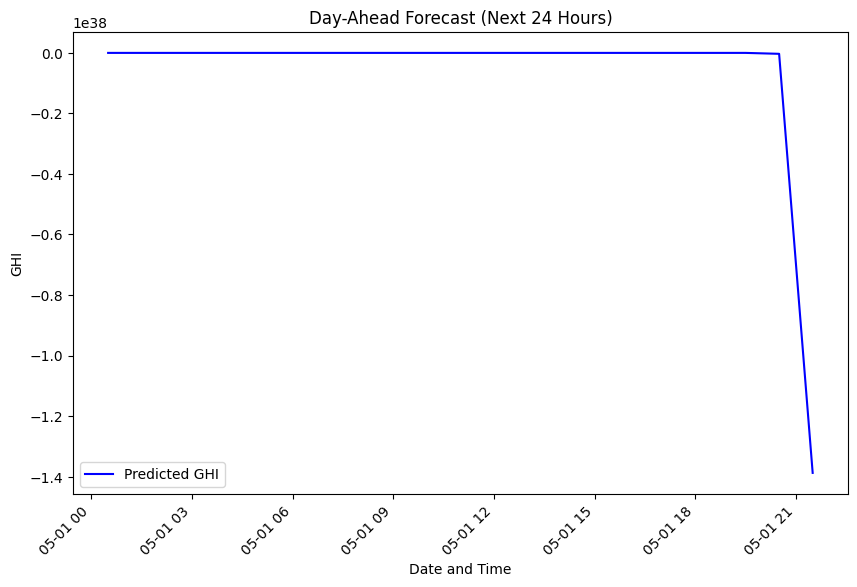

In [171]:
plt.figure(figsize=(10, 6))
plt.plot(time_range, predicted_values.flatten(), label='Predicted GHI', color='blue')  # Flatten to make it 1D
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date and Time')
plt.ylabel('GHI')
plt.title('Day-Ahead Forecast (Next 24 Hours)')

plt.legend()
plt.show()

In [172]:
# Note that I have to use scaler_y
y_test = output_scaler.inverse_transform(y_test)
y_train = output_scaler.inverse_transform(y_train)

In [173]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_cb_bilstm = prediction(catboost_model)

4/4 [==============================] - 1s 157ms/step


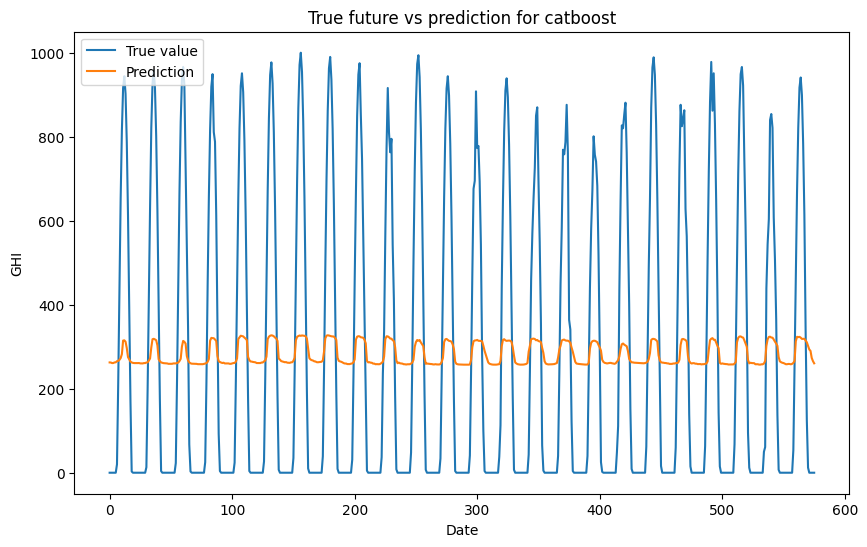

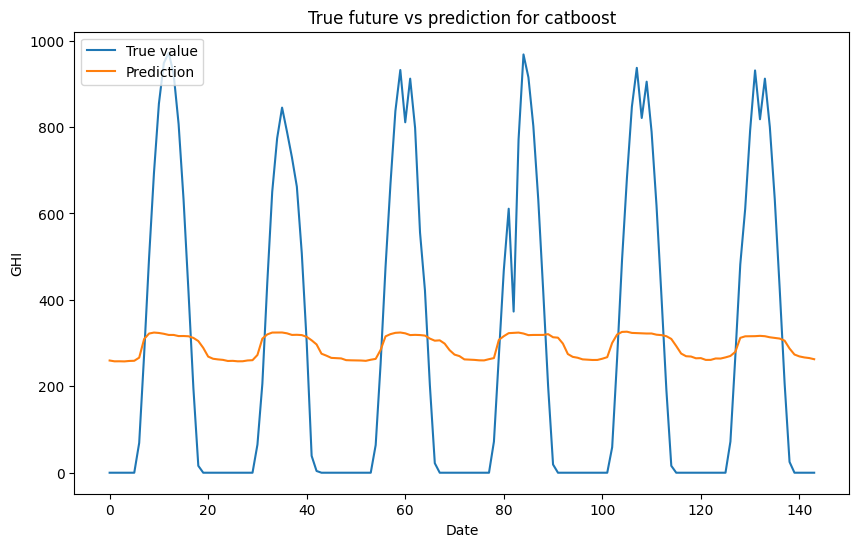

In [174]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True value')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
plot_future(catboost_output_train, 'catboost', y_trainy)
plot_future(catboost_output_test, 'catboost', y_testy)

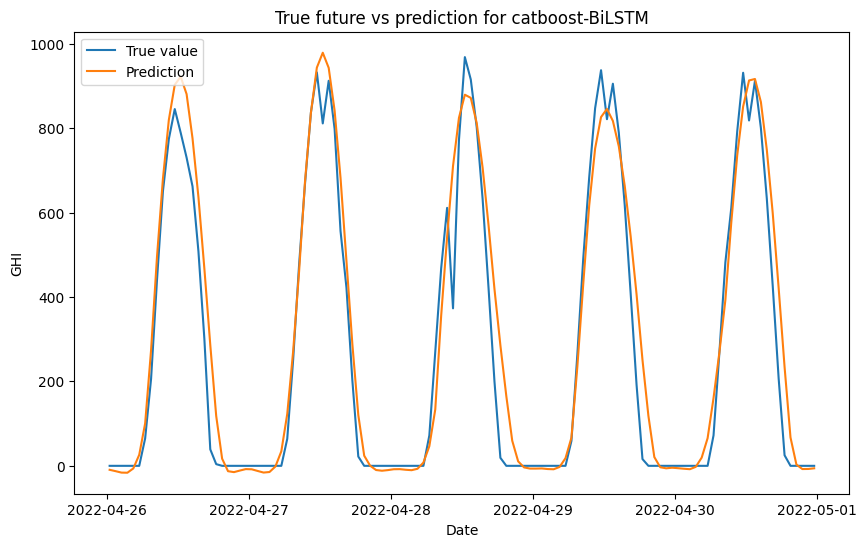

In [175]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)
    prediction_index = dataset.index[-range_future:]  

    plt.plot(prediction_index, np.array(y_test), label='True value')
    plt.plot(prediction_index, np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_cb_bilstm, 'catboost-BiLSTM', y_test)

In [176]:
# Evaluate model performance on training and test sets
evaluate_model(y_trainy, catboost_output_train, 'CatBoost', 'Training')
evaluate_model(y_testy, catboost_output_test, 'CatBoost', 'Testing')

In [177]:
evaluate_model(y_test, prediction_cb_bilstm, 'CatBoost-BiLSTM', 'Testing')


In [178]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'CatBoost-BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
6,CatBoost-BiLSTM,Testing,58.406798,8020.789383,89.55886,0.931225


## xgb-bilstm

In [179]:

data = read_data()


# dataset = data[['Temperature', 'DNI', 'DHI', 'GHI', 'Pressure', 'Wind Speed']]
dataset = data[['Temperature', 'GHI', 'Pressure', 'Wind Speed']]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_49008/2362433901.py:79: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


In [180]:
train_size = int(len(dataset)*0.8)
train_dataset, test_dataset = dataset.iloc[:train_size], dataset.iloc[train_size:]

In [181]:
# Split train data to X and y
X_trainy = train_dataset.drop('GHI', axis = 1)
y_trainy = train_dataset.loc[:,['GHI']]

# Split test data to X and y
X_testy = test_dataset.drop('GHI', axis = 1)
y_testy = test_dataset.loc[:,['GHI']]

In [182]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

xgb.fit(X_trainy, y_trainy)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [183]:
xgb_output_train = xgb.predict(X_trainy)
xgb_output_test = xgb.predict(X_testy)

In [184]:
# input_scaler = MinMaxScaler(feature_range = (0,1))
# output_scaler = MinMaxScaler(feature_range = (0,1))

# input_scaler = MinMaxScaler()
# output_scaler = MinMaxScaler()

# input_scaler, output_scaler = minmaxscaling()

input_scaler.fit(xgb_output_train.reshape(-1, 1))
# output_scaler.fit(xgb_output_test.reshape(-1, 1))

train_x_norm = input_scaler.transform(xgb_output_train.reshape(-1, 1))
test_x_norm = input_scaler.transform(xgb_output_test.reshape(-1, 1))


In [185]:

output_scaler.fit(y_trainy)

train_y_norm = output_scaler.transform(y_trainy)
test_y_norm = output_scaler.transform(y_testy)

In [186]:
# def create_dataset (X, y, time_steps = 1):
#     Xs, ys = [], []
    
#     for i in range(len(X)-time_steps):
#         v = X[i:i+time_steps, :]
#         Xs.append(v)
#         ys.append(y[i+time_steps])
        
#     return np.array(Xs), np.array(ys)

TIME_STEPS = 24
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)


# X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape) #
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape) #

X_train.shape:  (120, 24, 1)
y_train.shape:  (552, 1)
X_test.shape:  (120, 24, 1)
y_test.shape:  (552, 1)


In [187]:
xgb_model = build_bilstm_model(time_step)
xgb_history = xgb_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
9/9 [==============================] - 13s 1s/step - loss: 0.1172 - val_loss: 0.0581
Epoch 2/20
9/9 [==============================] - 9s 1s/step - loss: 0.0405 - val_loss: 0.0236
Epoch 3/20
9/9 [==============================] - 9s 999ms/step - loss: 0.0145 - val_loss: 0.0182
Epoch 4/20
9/9 [==============================] - 9s 970ms/step - loss: 0.0120 - val_loss: 0.0285
Epoch 5/20
9/9 [==============================] - 9s 955ms/step - loss: 0.0098 - val_loss: 0.0194
Epoch 6/20
9/9 [==============================] - 9s 1s/step - loss: 0.0093 - val_loss: 0.0147
Epoch 7/20
9/9 [==============================] - 9s 1s/step - loss: 0.0082 - val_loss: 0.0145
Epoch 8/20
9/9 [==============================] - 9s 1s/step - loss: 0.0080 - val_loss: 0.0127
Epoch 9/20
9/9 [==============================] - 8s 937ms/step - loss: 0.0073 - val_loss: 0.0124
Epoch 10/20
9/9 [==============================] - 8s 940ms/step - loss: 0.0074 - val_loss: 0.0126
Epoch 11/20
9/9 [================

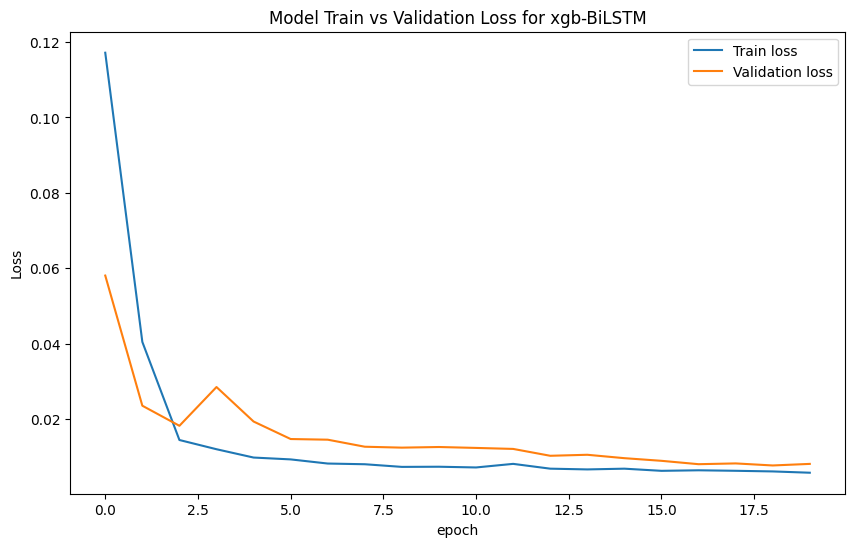

In [188]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (xgb_history, 'xgb-BiLSTM')

In [189]:
# Note that I have to use scaler_y
y_test = output_scaler.inverse_transform(y_test)
y_train = output_scaler.inverse_transform(y_train)

In [190]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_xgb_bilstm = prediction(xgb_model)

4/4 [==============================] - 1s 134ms/step


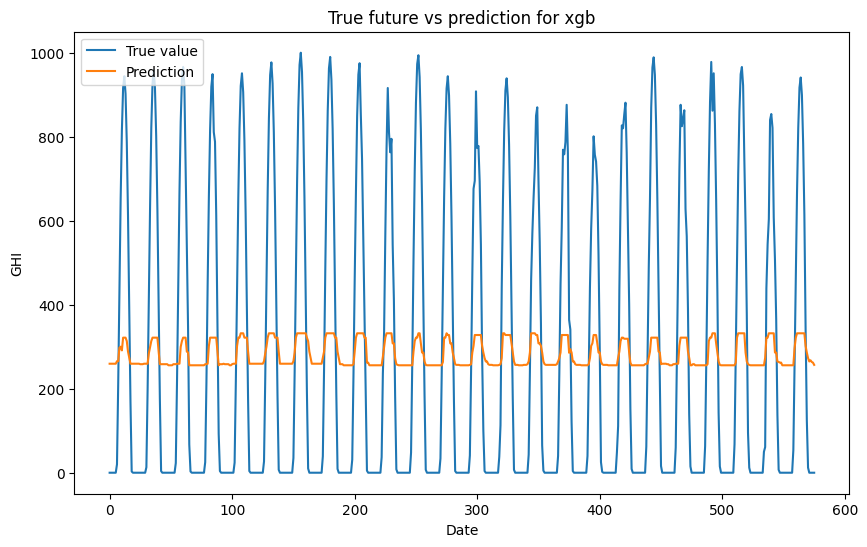

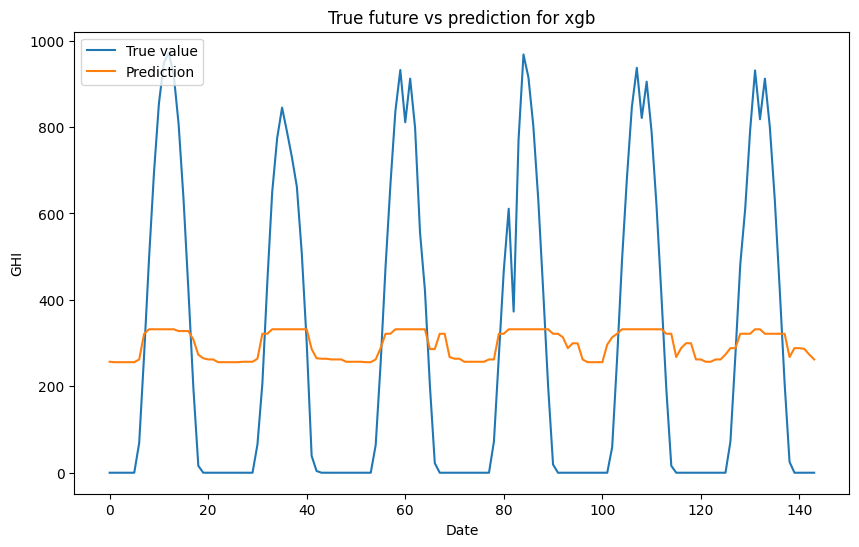

In [191]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True value')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
plot_future(xgb_output_train, 'xgb', y_trainy)
plot_future(xgb_output_test, 'xgb', y_testy)

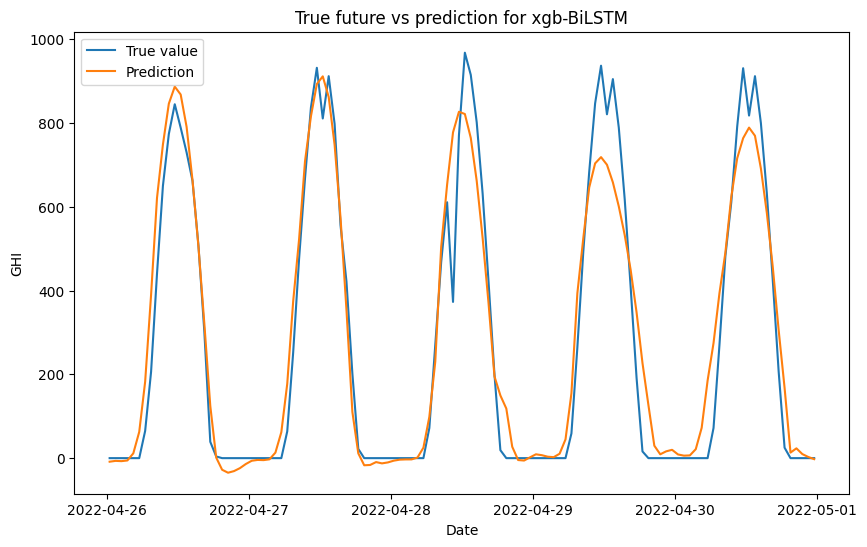

In [192]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)
    prediction_index = dataset.index[-range_future:]  

    plt.plot(prediction_index, np.array(y_test), label='True value')
    plt.plot(prediction_index, np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_xgb_bilstm, 'xgb-BiLSTM', y_test)

In [193]:
# Evaluate model performance on training and test sets
evaluate_model(y_trainy, xgb_output_train, 'xgb', 'Training')
evaluate_model(y_testy, xgb_output_test, 'xgb', 'Testing')

In [194]:
evaluate_model(y_test, prediction_xgb_bilstm, 'xgb-BiLSTM', 'Testing')

In [195]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'xgb-BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
9,xgb-BiLSTM,Testing,59.762993,8127.163275,90.150781,0.930313


## lightgbm-bilstm

In [196]:
data = read_data()

# dataset = data[['Temperature', 'DNI', 'DHI', 'GHI', 'Pressure', 'Wind Speed']]
dataset = data[['Temperature', 'GHI', 'Pressure', 'Wind Speed']]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_49008/2362433901.py:79: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


In [197]:
train_size = int(len(dataset)*0.8)
train_dataset, test_dataset = dataset.iloc[:train_size], dataset.iloc[train_size:]

In [198]:
# Split train data to X and y
X_trainy = train_dataset.drop('GHI', axis = 1)
y_trainy = train_dataset.loc[:,['GHI']]

# Split test data to X and y
X_testy = test_dataset.drop('GHI', axis = 1)
y_testy = test_dataset.loc[:,['GHI']]

In [199]:
lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.001, max_depth=5, verbosity=-1)
lgbm.fit(X_trainy, y_trainy)

LGBMRegressor(learning_rate=0.001, max_depth=5, verbosity=-1)

In [200]:
lgbm_output_train = lgbm.predict(X_trainy)
lgbm_output_test = lgbm.predict(X_testy)

In [201]:
# input_scaler = MinMaxScaler(feature_range = (0,1))
# output_scaler = MinMaxScaler(feature_range = (0,1))

# input_scaler = MinMaxScaler()
# output_scaler = MinMaxScaler()

input_scaler, output_scaler = minmaxscaling()

input_scaler.fit(lgbm_output_train.reshape(-1, 1))
# output_scaler.fit(lgbm_output_test.reshape(-1, 1))

train_x_norm = input_scaler.transform(lgbm_output_train.reshape(-1, 1))
test_x_norm = input_scaler.transform(lgbm_output_test.reshape(-1, 1))


In [202]:

output_scaler.fit(y_trainy)

train_y_norm = output_scaler.transform(y_trainy)
test_y_norm = output_scaler.transform(y_testy)

In [203]:
# def create_dataset (X, y, time_steps = 1):
#     Xs, ys = [], []
    
#     for i in range(len(X)-time_steps):
#         v = X[i:i+time_steps, :]
#         Xs.append(v)
#         ys.append(y[i+time_steps])
        
#     return np.array(Xs), np.array(ys)

TIME_STEPS = 24
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)


# X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape) #
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape) #

X_train.shape:  (120, 24, 1)
y_train.shape:  (552, 1)
X_test.shape:  (120, 24, 1)
y_test.shape:  (552, 1)


In [204]:
lgbm_model = build_bilstm_model(time_step)
lgbm_history = lgbm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
9/9 [==============================] - 11s 988ms/step - loss: 0.0955 - val_loss: 0.0632
Epoch 2/20
9/9 [==============================] - 8s 915ms/step - loss: 0.0268 - val_loss: 0.0378
Epoch 3/20
9/9 [==============================] - 3s 368ms/step - loss: 0.0147 - val_loss: 0.0365
Epoch 4/20
9/9 [==============================] - 3s 390ms/step - loss: 0.0128 - val_loss: 0.0300
Epoch 5/20
9/9 [==============================] - 3s 313ms/step - loss: 0.0109 - val_loss: 0.0196
Epoch 6/20
9/9 [==============================] - 3s 305ms/step - loss: 0.0099 - val_loss: 0.0155
Epoch 7/20
9/9 [==============================] - 3s 319ms/step - loss: 0.0094 - val_loss: 0.0131
Epoch 8/20
9/9 [==============================] - 3s 309ms/step - loss: 0.0091 - val_loss: 0.0127
Epoch 9/20
9/9 [==============================] - 3s 301ms/step - loss: 0.0084 - val_loss: 0.0125
Epoch 10/20
9/9 [==============================] - 3s 307ms/step - loss: 0.0084 - val_loss: 0.0116
Epoch 11/20
9/9 [=

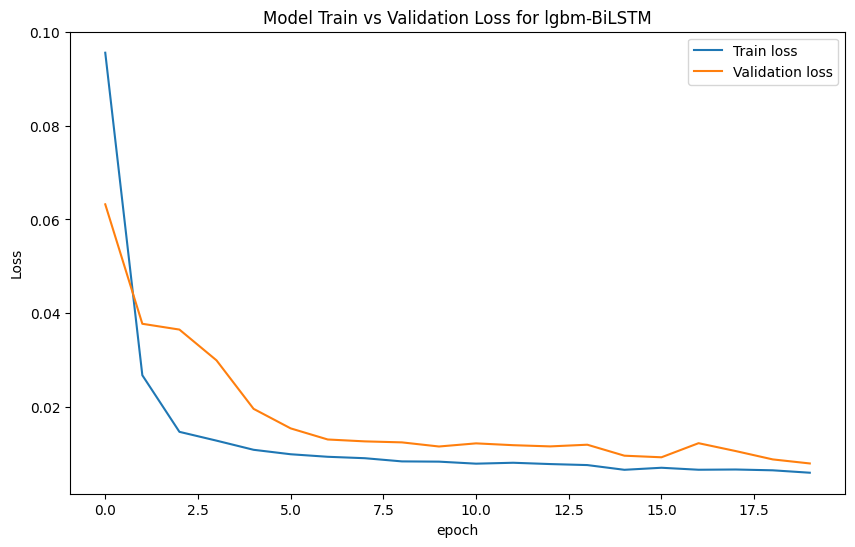

In [205]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (lgbm_history, 'lgbm-BiLSTM')

In [206]:
# Note that I have to use scaler_y
y_test = output_scaler.inverse_transform(y_test)
y_train = output_scaler.inverse_transform(y_train)

In [207]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_lgbm_bilstm = prediction(lgbm_model)

4/4 [==============================] - 0s 54ms/step


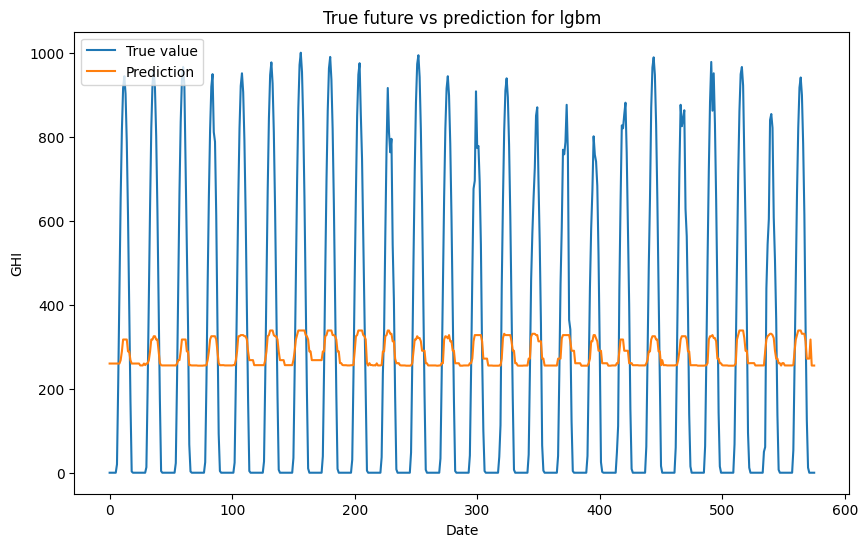

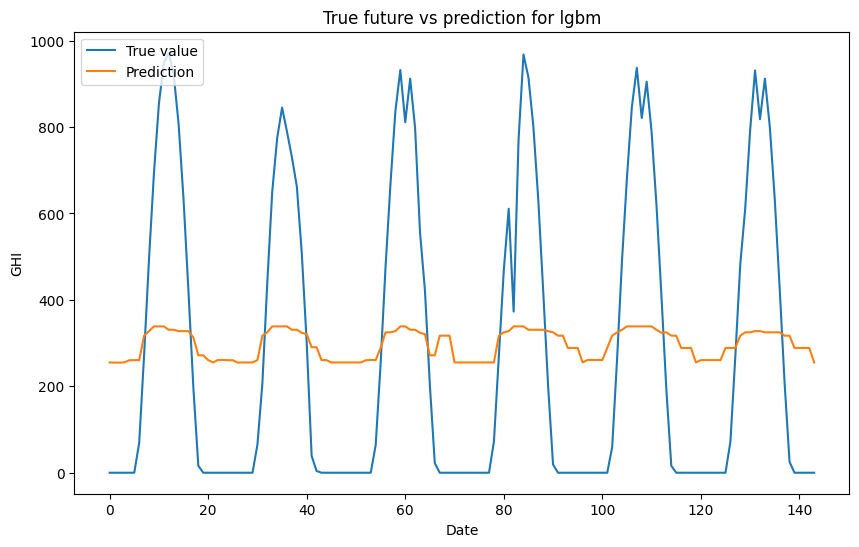

In [208]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True value')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
plot_future(lgbm_output_train, 'lgbm', y_trainy)
plot_future(lgbm_output_test, 'lgbm', y_testy)

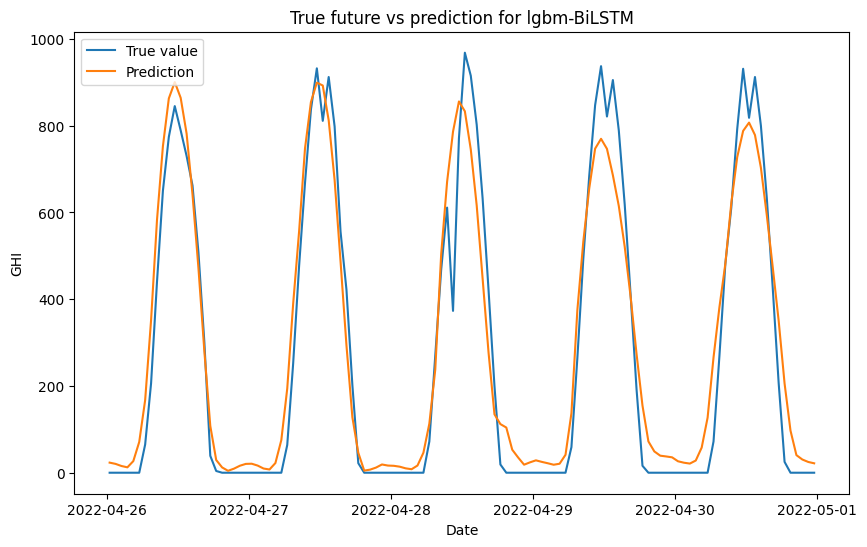

In [209]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)
    prediction_index = dataset.index[-range_future:]  

    plt.plot(prediction_index, np.array(y_test), label='True value')
    plt.plot(prediction_index, np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_lgbm_bilstm, 'lgbm-BiLSTM', y_test)

In [210]:
# Evaluate model performance on training and test sets
evaluate_model(y_trainy, lgbm_output_train, 'lgbm', 'Training')
evaluate_model(y_testy, lgbm_output_test, 'lgbm', 'Testing')

In [211]:
evaluate_model(y_test, prediction_lgbm_bilstm, 'lgbm-BiLSTM', 'Testing')

In [212]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'lgbm-BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
12,lgbm-BiLSTM,Testing,65.20904,7972.687665,89.289908,0.931638


### Results

In [213]:
def highlight_bilstm_rows(row):
  if 'BiLSTM' in row['Model']:
    return ['background-color: rgba(255, 255, 0, 0.4)'] * len(row)
  else:
    return [''] * len(row)

In [214]:
results_df = pd.DataFrame(evaluation_results)
styled_results_df = results_df.style.apply(highlight_bilstm_rows, axis=1)
print("\nevaluation metrics table: ")
styled_results_df


evaluation metrics table: 


,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Testing,46.768450,5848.908008,76.478154,0.949848
1,gbdt,Training,291.013025,104886.029070,323.861126,0.156873
2,gbdt,Testing,288.724006,102424.748629,320.038667,0.146650
3,GBDT-BiLSTM,Testing,63.175026,8552.562955,92.480068,0.926666
4,CatBoost,Training,296.355002,108985.077301,330.128880,0.123923
5,CatBoost,Testing,293.022207,105712.388546,325.134416,0.119259
6,CatBoost-BiLSTM,Testing,58.406798,8020.789383,89.558860,0.931225
7,xgb,Training,291.594944,105490.206369,324.792559,0.152016
8,xgb,Testing,289.743137,102975.412018,320.897822,0.142062
9,xgb-BiLSTM,Testing,59.762993,8127.163275,90.150781,0.930313


In [215]:
history_to_save = {
    'bilstm_history': bilstm_history.history,
    'gbdt_history': gbdt_history.history,
    'catboost_history': catboost_history.history,
    'xgb_history': catboost_history.history,
    'lgbm_history': catboost_history.history

}

with open('model_histories.pkl', 'wb') as f:
    pickle.dump(history_to_save, f)

In [216]:
with open('model_histories.pkl', 'rb') as f:
    loaded_histories = pickle.load(f)

# Access individual histories
bilstm_history_loaded = loaded_histories['bilstm_history']
gbdt_history_loaded = loaded_histories['gbdt_history']
catboost_history_loaded = loaded_histories['catboost_history']
xgb_history_loaded = loaded_histories['xgb_history']
lgbm_history_loaded = loaded_histories['lgbm_history']

In [217]:
def regression_plot(model_prediction, y_test):
  true_values = y_test.flatten()
  predicted_values = model_prediction.flatten()

  plt.figure(figsize=(10, 6))
  sns.scatterplot(x=true_values, y=predicted_values, color='blue', alpha=0.6, label='prediction vs actuals')

  max_val=max(max(true_values), max(predicted_values))
  min_val=min(min(true_values), min(predicted_values))
  plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="Perfect Fit (y=x)")

  plt.xlabel("Actual Values")
  plt.ylabel("Predicted Values")
  plt.title("Regression Plot: Predictions vs Actual Values")
  plt.legend()
  plt.grid(True)

  # Show the plot
  plt.show()

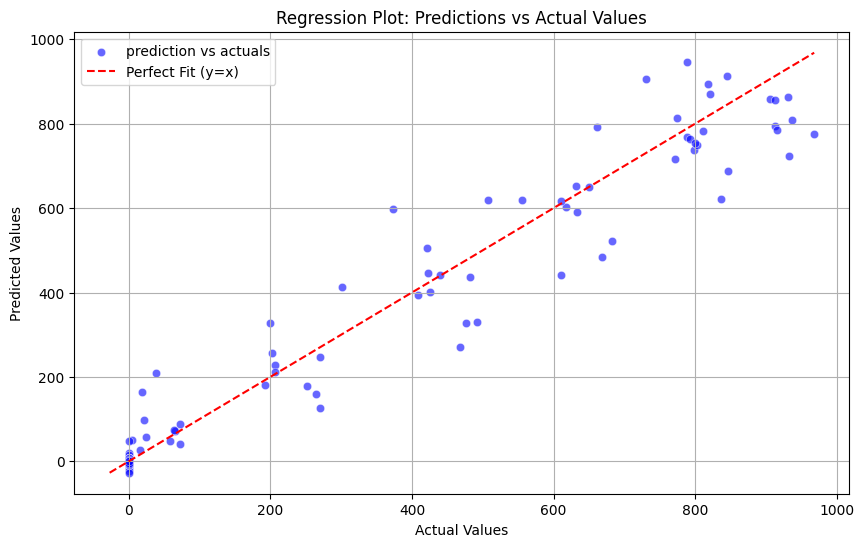

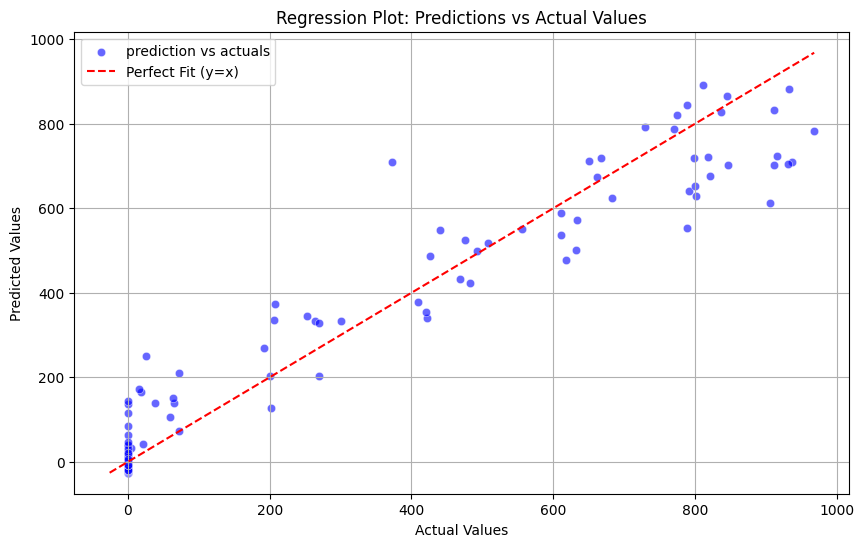

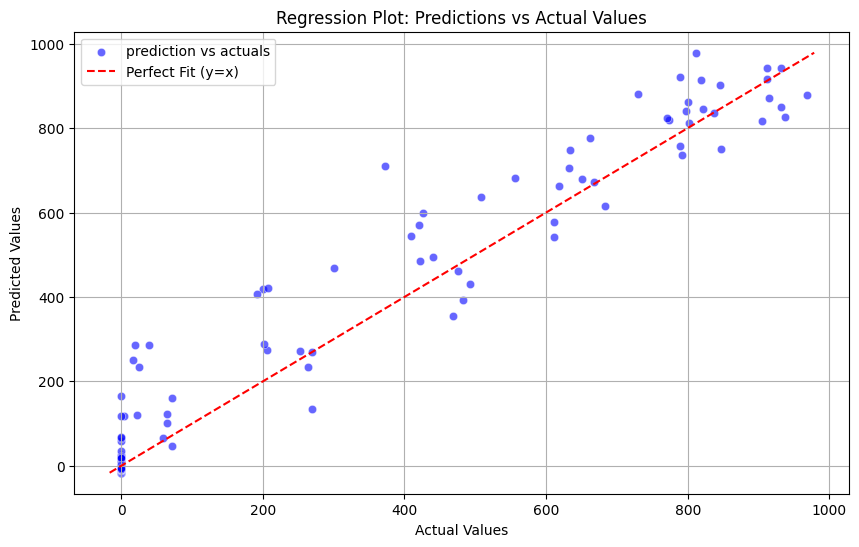

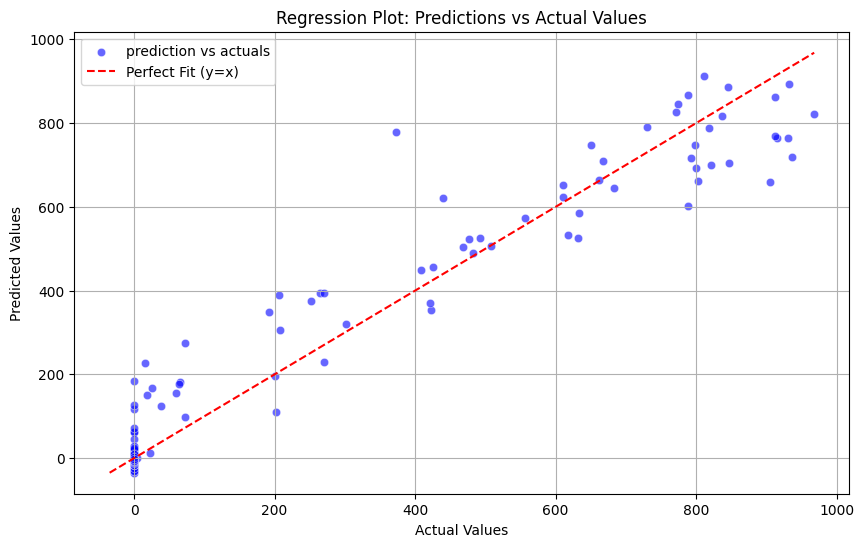

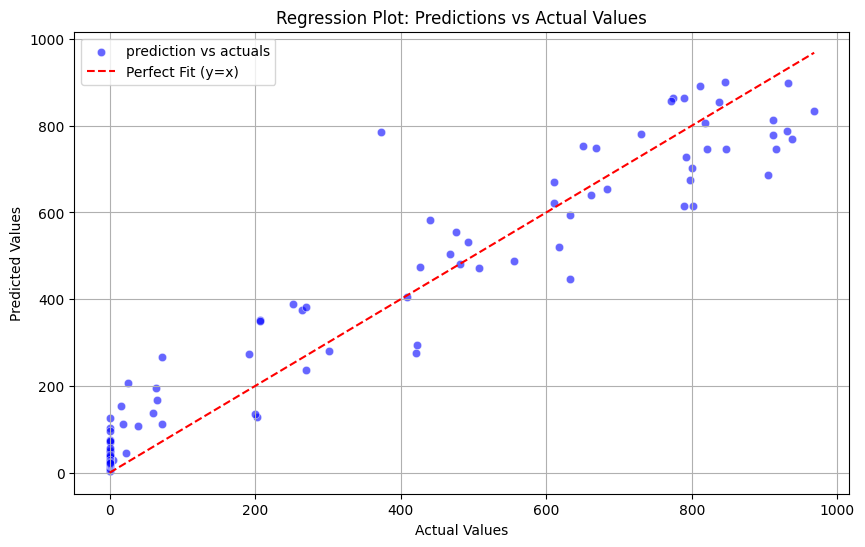

In [218]:
regression_plot(prediction_bilstm, y_test)

regression_plot(prediction_gbdt_bilstm, y_test)

regression_plot(prediction_cb_bilstm, y_test)

regression_plot(prediction_xgb_bilstm, y_test)

regression_plot(prediction_lgbm_bilstm, y_test)


In [219]:
bilstm_model.save('bilstm_model.h5')
gbdt_model.save('gbdt_model.h5')
catboost_model.save('catboost_model.h5')
xgb_model.save('xgb_model.h5')
lgbm_model.save('lgbm_model.h5')

models_info = {
    'bilstm_model_path': 'bilstm_model.h5',
    'gbdt_model_path': 'gbdt_model.h5',
    'catboost_model_path': 'catboost_model.h5',
    'xgb_model_path': 'xgb_model.h5',
    'lgbm_model_path': 'lgbm_model.h5'
}

with open('all_models_info.pkl', 'wb') as f:
    pickle.dump(models_info, f)

print("All models and paths are saved successfully.")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


All models and paths are saved successfully.


In [220]:
from tensorflow.keras.models import load_model

with open('all_models_info.pkl', 'rb') as f:
    models_info = pickle.load(f)

bilstm_model = load_model(models_info['bilstm_model_path'])
gbdt_model = load_model(models_info['gbdt_model_path'])
catboost_model = load_model(models_info['catboost_model_path'])
xgb_model = load_model(models_info['xgb_model_path'])
lgbm_model = load_model(models_info['lgbm_model_path'])

print("All models are loaded successfully.")


All models are loaded successfully.


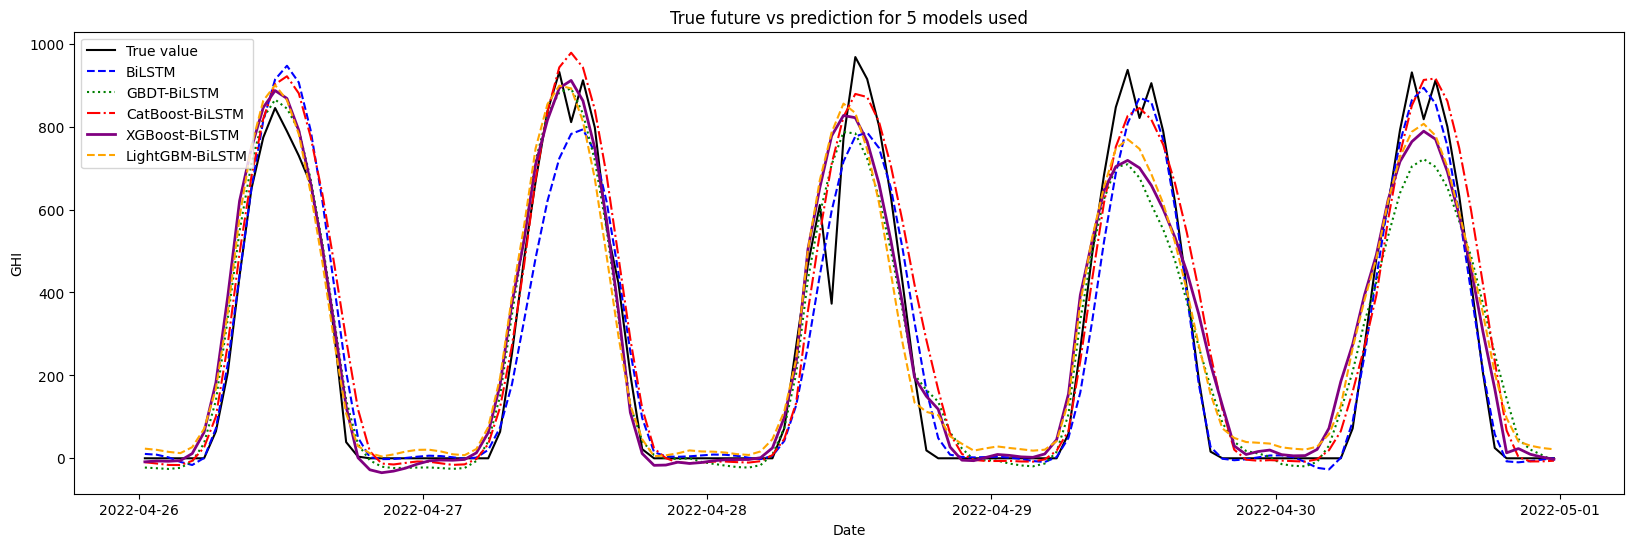

In [221]:
def plot_models_pred(pred_b, pred_gbdt, pred_cb, pred_xgb, pred_lgbm, y_test):
    
    plt.figure(figsize=(20, 6))
    
    range_future = len(pred_b)
    prediction_index = dataset.index[-range_future:]  

    # plt.plot(prediction_index, np.array(y_test), label='True value', )
    # plt.plot(prediction_index, np.array(pred_b),label='BiLSTM')
    # plt.plot(prediction_index, np.array(pred_gbdt),label='GBDT-BiLSTM')
    # plt.plot(prediction_index, np.array(pred_cb),label='CatBoost-BiLSTM')
    # plt.plot(prediction_index, np.array(pred_xgb),label='XGBoost-BiLSTM')
    # plt.plot(prediction_index, np.array(pred_lgbm),label='LightGBM-BiLSTM')
    plt.plot(prediction_index, np.array(y_test), label='True value', linestyle='-', color='black')  # Solid line
    plt.plot(prediction_index, np.array(pred_b), label='BiLSTM', linestyle='--', color='blue')  # Dashed line
    plt.plot(prediction_index, np.array(pred_gbdt), label='GBDT-BiLSTM', linestyle=':', color='green')  # Dotted line
    plt.plot(prediction_index, np.array(pred_cb), label='CatBoost-BiLSTM', linestyle='-.', color='red')  # Dash-dot line
    plt.plot(prediction_index, np.array(pred_xgb), label='XGBoost-BiLSTM', linestyle='-', color='purple', linewidth=2)  # Solid line, thicker
    plt.plot(prediction_index, np.array(pred_lgbm), label='LightGBM-BiLSTM', linestyle='--', color='orange')  # Dashed line


    plt.title('True future vs prediction for 5 models used')
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('GHI')

plot_models_pred(prediction_bilstm, prediction_gbdt_bilstm, prediction_cb_bilstm, prediction_xgb_bilstm, prediction_lgbm_bilstm, y_test )

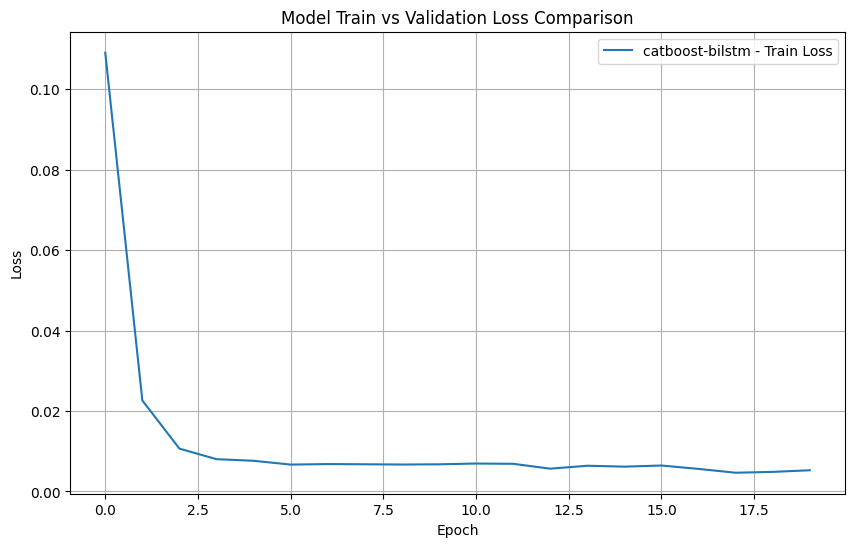

In [229]:
def plot_losses_curves(history, model_names):
  plt.figure(figsize=(10, 6))
  plt.plot(history['loss'], label=f'{model_names} - Train Loss')
  plt.title('Model Train vs Validation Loss Comparison')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(loc='upper right')
  plt.grid()
  plt.show()

plot_losses_curves(catboost_history_loaded, 'catboost-bilstm')

In [257]:
def plot_multiple_losses(histories, model_names):
    """
    Plot training and validation loss for multiple models on the same graph.
    
    Parameters:
        histories (list): A list of dictionaries containing 'loss' and 'val_loss'.
        model_names (list): A list of names corresponding to the models.
    """
    plt.figure(figsize=(10, 6))
    
    # Iterate through each model's history and plot its loss curves
    counter = 0
    for history, model_name in zip(histories, model_names):
        if 'loss' in history:  # Check if 'loss' exists
            plt.plot(history['val_loss'], label=f'{model_name} - Train Loss')
            plt.plot(history['loss'], label=f'{model_name} - Validation Loss')
        else:
            print(f"Warning: 'loss' key not found for {model_name}")
    # plt.plot(catboost_history['loss'], label=f'catboost_bilstm - Train Loss')
    
    # Set titles and labels
    plt.title('Model Train vs Validation Loss Comparison')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

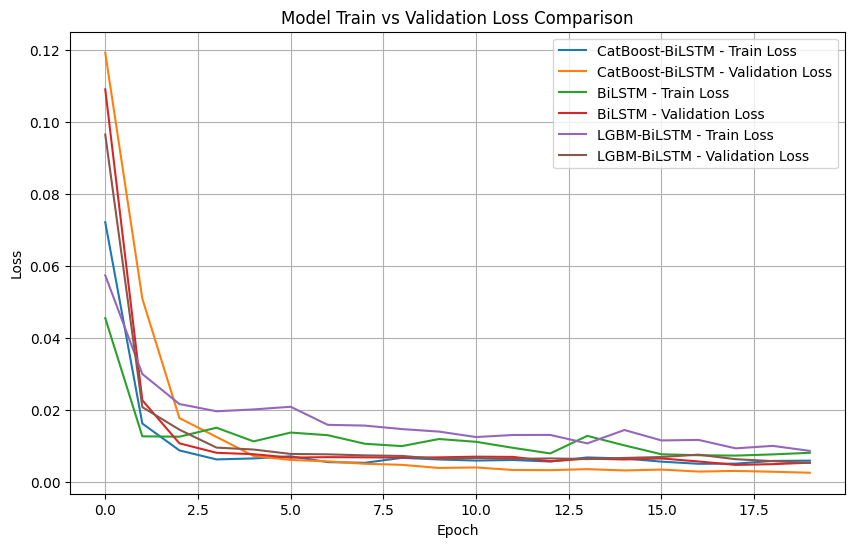

In [258]:
plot_multiple_losses(
    histories=[
        bilstm_history_loaded,
        lgbm_history_loaded,
        gbdt_history_loaded
    ],
    model_names=[
        'CatBoost-BiLSTM',
        'BiLSTM',
        'LGBM-BiLSTM'
    ]
)